# SIPA 4 Image Analysis

In [3]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import pytesseract
import shutil
import cv2
import os

# psm 6 = Assume a single uniform block of text.
config_tesseract = '--tessdata-dir ./ttesseract_langs --psm 6'

In [12]:
def display_images(folder_path, title=None):
  # Get the list of all files in the directory
  filenames = os.listdir(folder_path)
  
  # Initialize the figure and axis
  fig, axs = plt.subplots(4, 2, figsize=(15, 15), facecolor='#808080')
  
  # Iterate through all files and plot the image
  for i, f in enumerate(filenames):
    img = cv2.imread(os.path.join(folder_path, f))
    axs[i//2, i%2].imshow(img)
    axs[i//2, i%2].axis('off')
    axs[i//2, i%2].grid(False)
    axs[i//2, i%2].set_title(f)
    # plt.subplots_adjust(wspace=0, hspace=0)
    
  # Remove the grid lines from the empty subplots
  for ax in axs.flat:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('#808080')
    for sp in ax.spines.values():
      sp.set_visible(False)
  
  # Set the overall chart title
  fig.suptitle(title, fontsize=50, fontweight=700)
  
  plt.show()

IndexError: index 4 is out of bounds for axis 0 with size 4

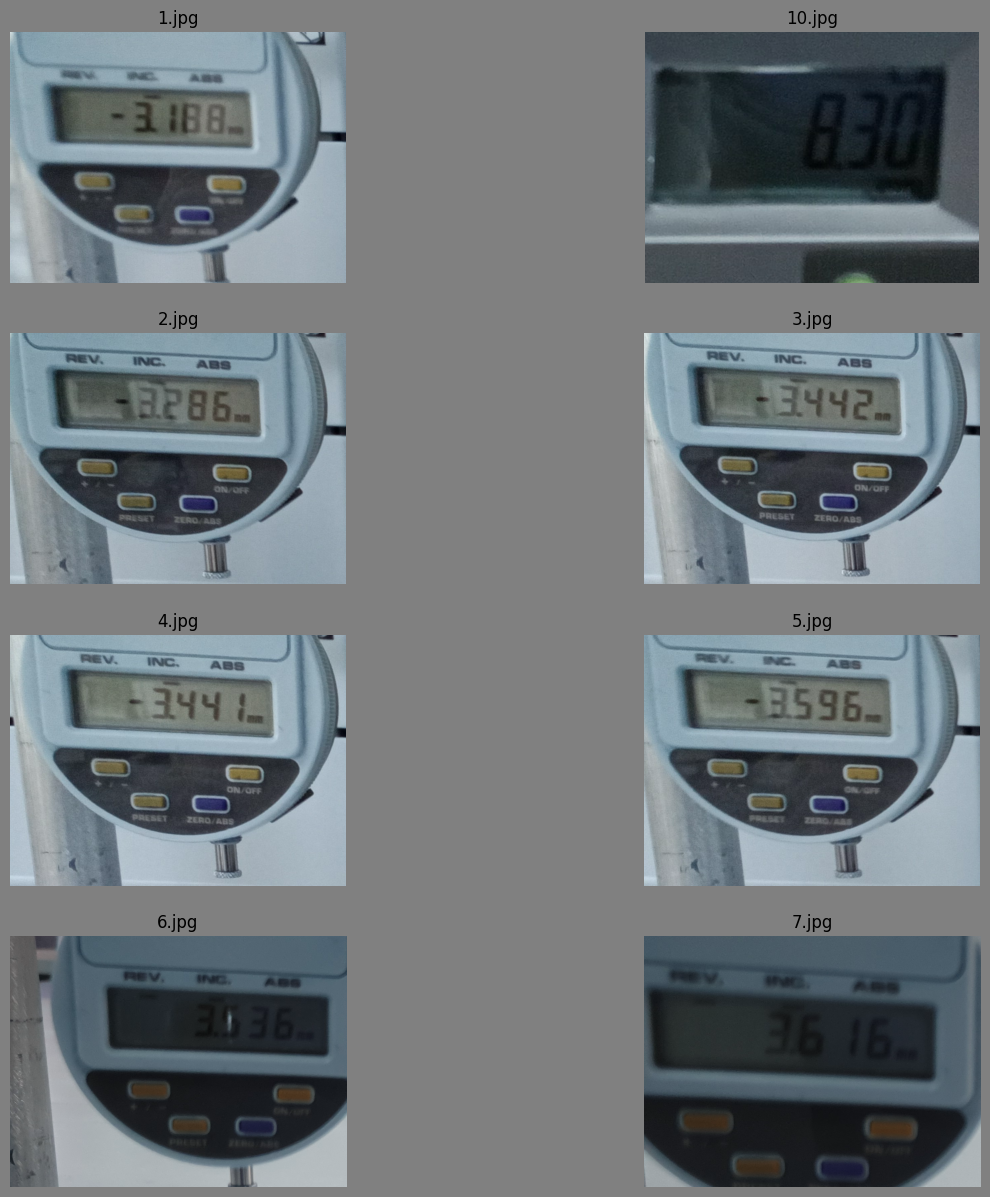

In [13]:
display_images("./sipaimages/4", "Sipa 4 Images")

In [14]:
def read_input_file_list():

    # Read image file list
    input_data = pd.read_csv(r'./labelled_images_sipa4.txt', names=["file_name","seen_value","ncol2","ncol3"], sep="\t", header=None)
    input_data = input_data.reset_index()

    # Display Image Count
    print(len(input_data), "input images to process!!")
    return input_data

In [15]:
def read_resize_data(input_file, size=160):
    img = cv2.imread(input_file)
    
    width = size
    height = size
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    return resized

In [16]:
def get_text(image):

    # Read text from image using Seven Segment training data
    text_ssd = pytesseract.image_to_string(image, lang="ssd", config=config_tesseract)

    # Read text from image using English character training data
    text_eng = pytesseract.image_to_string(image, lang="eng", config=config_tesseract)
    
    # Clean text
    text_ssd = ''.join(c for c in text_ssd if c.isdigit() or c == '.')
    text_eng = ''.join(c for c in text_eng if c.isdigit() or c == '.')

    return text_ssd, text_eng

## Image Processing Functions

In [17]:
def process_file_thresh(input_file, size):

    # Get image data
    # img = read_input_data(input_file)
    img = read_resize_data(input_file, size)

    # Convert to RGB (three dimensions)
    nimRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to gray (one dimension)
    nimGray = cv2.cvtColor(nimRGB, cv2.COLOR_BGR2GRAY)

    # Set the minimum to gray and max to white
    min_threshold = 127
    max_threshold = 255

    # Binary Thresh
    value, nimThresh = cv2.threshold(nimGray, min_threshold, max_threshold, cv2.THRESH_BINARY)

    # Get Text for Seven Segment and English
    text_ssd, text_eng = get_text(nimThresh)
    
    return text_ssd, text_eng
    

In [18]:
def process_file_closing(input_file, size):

    # Get image data
    # img = read_input_data(input_file)
    img = read_resize_data(input_file, size)

    # Convert to RGB (three dimensions)
    nimRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to gray (one dimension)
    nimGray = cv2.cvtColor(nimRGB, cv2.COLOR_BGR2GRAY)

    # Perform Dilation using a 5x5 matrix
    cdilation = cv2.dilate(nimGray, np.ones((5,5), np.uint8))

    # PErform Erod using a 5x5 matrix
    nimClosing = cv2.erode(cdilation, np.ones((5,5), np.uint8))

    # Get Text for Seven Segment and English
    text_ssd, text_eng = get_text(nimClosing)
    
    return text_ssd, text_eng
    

In [19]:
def process_otsu(input_file, size):

    # Get image data
    # img = read_input_data(input_file)
    img = read_resize_data(input_file, size)

    
    # Convert to RGB (three dimensions)
    nimRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to gray (one dimension)
    nimGray = cv2.cvtColor(nimRGB, cv2.COLOR_BGR2GRAY)

    # 0 means threshold level which actually is omitted because we used CV_THRESH_OTSU flag
    min_threshold = 0

    # 255 is a value that is going to be assigned to respectively pixels in the result 
    # (namely, to all pixels which value in the source is greater then computed threshold level)
    max_threshold = 255

    # THRESH_BINARY | THRESH_OTSU is a required flag to perform Otsu thresholding. Because in fact we would like to perform binary thresholding,
    # so we use CV_THRESH_BINARY (you can use any of 5 flags opencv provides) combined with CV_THRESH_OTSU
    value, nimOTSU = cv2.threshold(nimGray, min_threshold, max_threshold, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Get Text for Seven Segment and English
    text_ssd, text_eng = get_text(nimOTSU)
    
    return text_ssd, text_eng

## Control Loop

In [20]:
def control_loop(size_to_process):
    input_array = []
    # print(size_to_process)

    for row in tqdm(input_data.iterrows()):

        input_file = row[1][1]
        seen_value = row[1][2]
        # print("input_file", input_file)

        # Thresh
        thresh_ssd, thresh_eng = process_file_thresh(input_file, size_to_process)
        
        # Dialation
        closing_ssd, closing_eng = process_file_closing(input_file, size_to_process)

        # OTSU
        otsu_ssd, otsu_eng = process_otsu(input_file, size_to_process)

        # Add text to array
        new_row = [input_file, seen_value, size_to_process, thresh_ssd, thresh_eng, closing_ssd, closing_eng, otsu_ssd, otsu_eng]

        input_array.append(new_row)

    return input_array


In [ ]:
input_data = read_input_file_list()
input_array = []
size_array = []

for size_to_process in range(50,650):

    loop_array = control_loop(size_to_process)

    size_array.append(loop_array)

size_array

In [23]:
sa = np.array(size_array)
sa.tofile("size_Array.csv", sep=",", format='%s')

## Analysis

In [24]:
df = pd.read_csv('size_Array.csv', header=None, delimiter=",", usecols=None)

In [25]:
df

,0,1,2,3,4,5,6,7,8,9,...,53990,53991,53992,53993,53994,53995,53996,53997,53998,53999
0,.\sipaimages\4\1.jpg,-3.188,50,11,NaN,1571,NaN,11,NaN,.\sipaimages\4\10.jpg,...,NaN,.\sipaimages\4\9.jpg,3.436,649,17,4,1.100104.01007,.,40074111,9


In [26]:
output_df = pd.DataFrame(columns = ['image_file', 'seen_data_numeric', 'size_used', 'thresh_ssd', 'thresh_eng', 'closing_ssd', 'closing_eng', 'mro_ssd', 'mro_eng'])

In [27]:
output_df = pd.DataFrame(columns = ['image_file', 'seen_data_numeric', 'size_used', 'closing_ssd', 'closing_eng', 'mro_ssd', 'mro_eng'])
t_count = 0
t_sipa_count = 0
sum_array = []
t_start_element = False
for (columnName, columnData) in df.iteritems():
    
    t_count += 1


    column_to_list = columnData.tolist()
    column_to_list_string = " ".join(str(column_to_list) for x in column_to_list)

    if "sipa" in column_to_list_string:
        t_start_element = True
        t_sipa_count += 1
        # This is the first field in the group
        t_field_count = 1
        
        image_file = column_to_list_string

        if column_to_list_string not in sum_array:
            sum_array.append(column_to_list_string)

    
    if t_field_count == 2:
        # print("field counnt 2")
        try:
            seen_data_numeric = pd.to_numeric(columnData)
        except:
            seen_data_numeric = column_to_list_string
        
    
    if t_field_count == 3:
        # print("field counnt 3")
        try:
            size_used = pd.to_numeric(columnData)
        except:
            size_used = column_to_list_string


    if t_field_count == 4:
        
        try:
            thresh_ssd = pd.to_numeric(columnData)
        except:
            thresh_ssd = column_to_list_string

    
    if t_field_count == 5:
        # print("field counnt 5")
        try:
            thresh_eng = pd.to_numeric(columnData)
        except:
            thresh_eng = column_to_list_string



    if t_field_count == 6:
        # print("field counnt 6")
        try:
            closing_ssd = pd.to_numeric(columnData)
        except:
            closing_ssd = column_to_list_string

    
    if t_field_count == 7:
        # print("field counnt 7")
        try:
            closing_eng = pd.to_numeric(columnData)
        except:
            closing_eng = column_to_list_string

    if t_field_count == 8:
        # print("field counnt 8")
        try:
            mro_ssd = pd.to_numeric(columnData)
        except:
            mro_ssd = column_to_list_string

    
    if t_field_count == 9:
        # print("field counnt 7")
        try:
            mro_eng = pd.to_numeric(columnData)
        except:
            mro_eng = column_to_list_string
        

        new_row = {
            'image_file' : image_file, 
            'seen_data_numeric' : seen_data_numeric, 
            'size_used' : size_used, 
            'thresh_ssd' : thresh_ssd, 
            'thresh_eng' : thresh_eng, 
            'closing_ssd' : closing_ssd, 
            'closing_eng' : closing_eng, 
            'mro_ssd' : mro_ssd, 
            'mro_eng' : mro_eng
            }
        # output_df = output_df.append(new_row, ignore_index=True)
        output_df = pd.concat([output_df, pd.DataFrame.from_records(new_row)])
        # write_row(image_file, seen_data_numeric, size_used, closing_ssd, closing_eng, mro_ssd, mro_eng)
    


    t_field_count += 1
        
        


print(t_count)
print(t_sipa_count)

54000
6000


In [28]:
output_df.to_csv("sipa4_data.csv")

In [29]:
sipa4_data = pd.read_csv("sipa4_data.csv", index_col=0)

## Count Analysis

Here we are taking the read analysis of the sipa images and counting the number of times each time the digits were successfully read.

In [30]:

# Get a list of the unique images in the dataframe
unique_images = sipa4_data['image_file'].unique()

# Initialize empty lists to store the counts

thresh_ssd_equal_counts = []
thresh_ssd_not_equal_counts = []
thresh_eng_equal_counts = []
thresh_eng_not_equal_counts = []

closing_ssd_equal_counts = []
closing_ssd_not_equal_counts = []
closing_eng_equal_counts = []
closing_eng_not_equal_counts = []

mro_ssd_equal_counts = []
mro_ssd_not_equal_counts = []
mro_eng_equal_counts = []
mro_eng_not_equal_counts = []

# Iterate over the unique images
for image in unique_images:
   

    # Filter the dataframe to include only rows with the current image
    image_df = sipa4_data[sipa4_data['image_file'] == image]


    
    # THRESH
    
    # Count the number of times seen_data_numeric is equal to thresh_ssd for the current image
    thresh_ssd_equal_count = image_df[image_df['seen_data_numeric'] == image_df['thresh_ssd']].shape[0]
    
    # Count the number of times seen_data_numeric is not equal to thresh_ssd for the current image
    thresh_ssd_not_equal_count = image_df[image_df['seen_data_numeric'] != image_df['thresh_ssd']].shape[0]

    # Count the number of times seen_data_numeric is equal to thresh_eng for the current image
    thresh_eng_equal_count = image_df[image_df['seen_data_numeric'] == image_df['thresh_eng']].shape[0]
    
    # Count the number of times seen_data_numeric is not equal to thresh_eng for the current image
    thresh_eng_not_equal_count = image_df[image_df['seen_data_numeric'] != image_df['thresh_eng']].shape[0]



    # CLOSING
    
    # Count the number of times seen_data_numeric is equal to closing_ssd for the current image
    closing_ssd_equal_count = image_df[image_df['seen_data_numeric'] == image_df['closing_ssd']].shape[0]
    
    # Count the number of times seen_data_numeric is not equal to closing_ssd for the current image
    closing_ssd_not_equal_count = image_df[image_df['seen_data_numeric'] != image_df['closing_ssd']].shape[0]

    # Count the number of times seen_data_numeric is equal to closing_eng for the current image
    closing_eng_equal_count = image_df[image_df['seen_data_numeric'] == image_df['closing_eng']].shape[0]
    
    # Count the number of times seen_data_numeric is not equal to closing_eng for the current image
    closing_eng_not_equal_count = image_df[image_df['seen_data_numeric'] != image_df['closing_eng']].shape[0]


    # MRO Counts   
    # Count the number of times seen_data_numeric is equal to mro_ssd for the current image
    mro_ssd_equal_count = image_df[image_df['seen_data_numeric'] == image_df['mro_ssd']].shape[0]
    
    # Count the number of times seen_data_numeric is not equal to mro_ssd for the current image
    mro_ssd_not_equal_count = image_df[image_df['seen_data_numeric'] != image_df['mro_ssd']].shape[0]

    # Count the number of times seen_data_numeric is equal to mro_eng for the current image
    mro_eng_equal_count = image_df[image_df['seen_data_numeric'] == image_df['mro_eng']].shape[0]
    
    # Count the number of times seen_data_numeric is not equal to mro_eng for the current image
    mro_eng_not_equal_count = image_df[image_df['seen_data_numeric'] != image_df['mro_eng']].shape[0]
    
    # Add the counts to the lists
    thresh_ssd_equal_counts.append(thresh_ssd_equal_count)
    thresh_ssd_not_equal_counts.append(thresh_ssd_not_equal_count)
    thresh_eng_equal_counts.append(thresh_eng_equal_count)
    thresh_eng_not_equal_counts.append(thresh_eng_not_equal_count)

    closing_ssd_equal_counts.append(closing_ssd_equal_count)
    closing_ssd_not_equal_counts.append(closing_ssd_not_equal_count)
    closing_eng_equal_counts.append(closing_eng_equal_count)
    closing_eng_not_equal_counts.append(closing_eng_not_equal_count)

    mro_ssd_equal_counts.append(mro_ssd_equal_count)
    mro_ssd_not_equal_counts.append(mro_ssd_not_equal_count)
    mro_eng_equal_counts.append(mro_eng_equal_count)
    mro_eng_not_equal_counts.append(mro_eng_not_equal_count)

# Create a new dataframe with the counts as columns
output_df = pd.DataFrame({
    'thresh_ssd_equal_count': thresh_ssd_equal_counts,
    'thresh_ssd_not_equal_count': thresh_ssd_not_equal_counts,
    'thresh_eng_equal_count': thresh_eng_equal_counts,
    'thresh_eng_not_equal_count': thresh_eng_not_equal_counts,
    'closing_ssd_equal_count': closing_ssd_equal_counts,
    'closing_ssd_not_equal_count': closing_ssd_not_equal_counts,
    'closing_eng_equal_count': closing_eng_equal_counts,
    'closing_eng_not_equal_count': closing_eng_not_equal_counts,
    'mro_ssd_equal_count': mro_ssd_equal_counts,
    'mro_ssd_not_equal_count': mro_ssd_not_equal_counts,
    'mro_eng_equal_count': mro_eng_equal_counts,
    'mro_eng_not_equal_count': mro_eng_not_equal_counts
}, index=unique_images)

# output_df.insert(0, 'image_file', unique_images.strip('[]'))

stripped_images = [image.strip("[]'") for image in unique_images]
output_df.insert(0, 'image_file', stripped_images)

# Save the output dataframe to a CSV file
output_df.to_csv('sipa4_count_analysis.csv', index=False, header=True)


## Sipa 4 Contrast thresh_eng

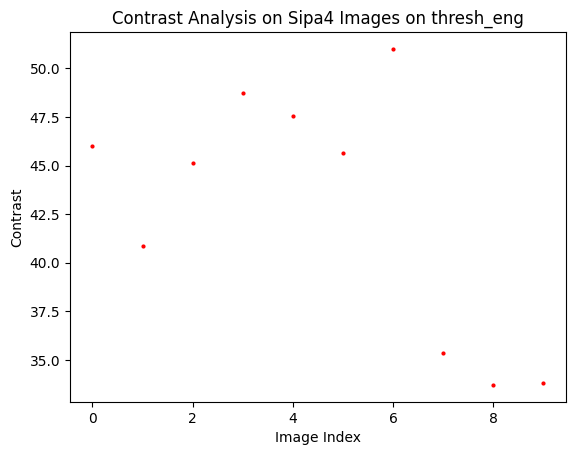

In [31]:
df = pd.read_csv('sipa4_count_analysis.csv')

# List to store the contrasts of the images
contrasts = []

# Loop through the rows in the dataframe
for index, row in df.iterrows():
    # Extract the file name from the list
    filename = row['image_file']

    # Load the image using OpenCV
    image = cv2.imread(filename)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the contrast of the image by calculating the standard deviation of the pixel intensities
    contrast = cv2.meanStdDev(gray_image)[1][0][0]

    # Add the contrast value to the list
    contrasts.append(contrast)

    # Check if thresh_eng_equal_count is greater than 0
    if row['thresh_eng_equal_count'] > 0:
        # If it is, plot the dot in green with a gradient
        plt.scatter(index, contrast, color=(0, row['thresh_eng_equal_count']/max(df['thresh_eng_equal_count']), 0), marker='o', s=4)
    else:
        # Otherwise, plot the dot in red
        plt.plot(index, contrast, 'ro', markersize=2)

# Add labels to the x and y axis
plt.xlabel('Image Index')
plt.ylabel('Contrast')
plt.title("Contrast Analysis on Sipa4 Images on thresh_eng")

plt.show()

## Sipa 4 Contrast thresh_ssd

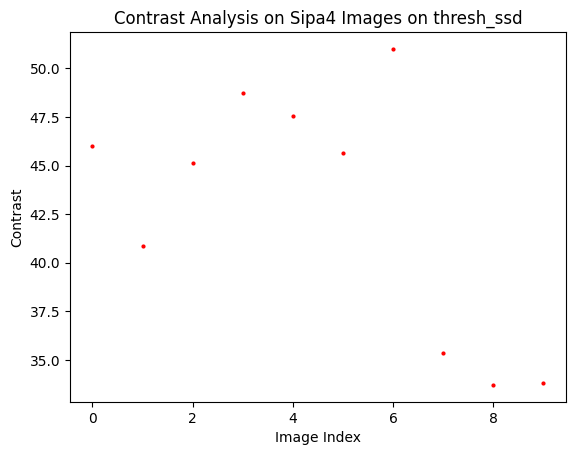

In [32]:
df = pd.read_csv('sipa4_count_analysis.csv')

# List to store the contrasts of the images
contrasts = []

# Loop through the rows in the dataframe
for index, row in df.iterrows():
    # Extract the file name from the list
    filename = row['image_file']

    # Load the image using OpenCV
    image = cv2.imread(filename)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the contrast of the image by calculating the standard deviation of the pixel intensities
    contrast = cv2.meanStdDev(gray_image)[1][0][0]

    # Add the contrast value to the list
    contrasts.append(contrast)

    # Check if thresh_ssd_equal_count is greater than 0
    if row['thresh_ssd_equal_count'] > 0:
        # If it is, plot the dot in green with a gradient
        plt.scatter(index, contrast, color=(0, row['thresh_ssd_equal_count']/max(df['thresh_ssd_equal_count']), 0), marker='o', s=4)
    else:
        # Otherwise, plot the dot in red
        plt.plot(index, contrast, 'ro', markersize=2)

# Add labels to the x and y axis
plt.xlabel('Image Index')
plt.ylabel('Contrast')
plt.title("Contrast Analysis on Sipa4 Images on thresh_ssd")

plt.show()

## Sipa3 Contrast closing_eng

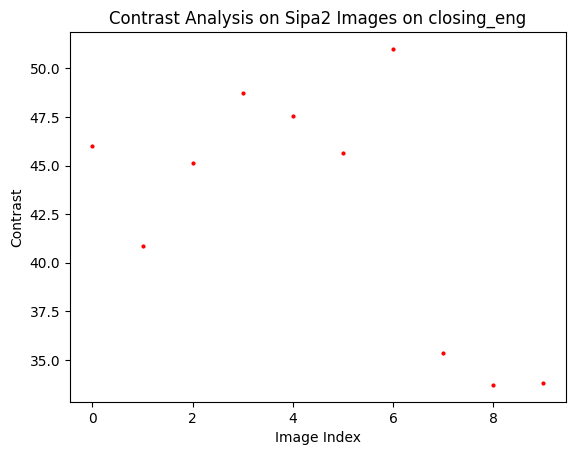

In [33]:
df = pd.read_csv('sipa4_count_analysis.csv')

# List to store the contrasts of the images
contrasts = []

# Loop through the rows in the dataframe
for index, row in df.iterrows():
    # Extract the file name from the list
    filename = row['image_file']

    # Load the image using OpenCV
    image = cv2.imread(filename)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the contrast of the image by calculating the standard deviation of the pixel intensities
    contrast = cv2.meanStdDev(gray_image)[1][0][0]

    # Add the contrast value to the list
    contrasts.append(contrast)

    # Check if closing_eng_equal_count is greater than 0
    if row['closing_eng_equal_count'] > 0:
        # If it is, plot the dot in green with a gradient
        plt.scatter(index, contrast, color=(0, row['closing_eng_equal_count']/max(df['closing_eng_equal_count']), 0), marker='o', s=4)
    else:
        # Otherwise, plot the dot in red
        plt.plot(index, contrast, 'ro', markersize=2)

# Add labels to the x and y axis
plt.xlabel('Image Index')
plt.ylabel('Contrast')
plt.title("Contrast Analysis on Sipa2 Images on closing_eng")

plt.show()

In [34]:
size_fields_df = sipa4_data[['size_used', 'seen_data_numeric', 'thresh_ssd', 'thresh_eng']]

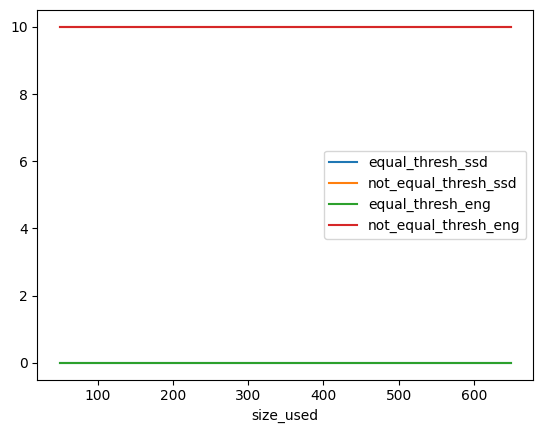

In [35]:
# group the data by the size_used field
grouped_data = size_fields_df.groupby('size_used')

# count the number of times seen_data_numeric equals mro_ssd and does not equal mro_ssd
equal_thresh_ssd = grouped_data['seen_data_numeric'].apply(lambda x: (x == grouped_data.get_group(x.name)['thresh_ssd']).sum())
not_equal_thresh_ssd = grouped_data['seen_data_numeric'].apply(lambda x: (x != grouped_data.get_group(x.name)['thresh_ssd']).sum())

# do the same for mro_eng
equal_thresh_eng = grouped_data['seen_data_numeric'].apply(lambda x: (x == grouped_data.get_group(x.name)['thresh_eng']).sum())
not_equal_thresh_eng = grouped_data['seen_data_numeric'].apply(lambda x: (x != grouped_data.get_group(x.name)['thresh_eng']).sum())

# create a new dataframe with the results
results_df = pd.DataFrame({'equal_thresh_ssd': equal_thresh_ssd,
                           'not_equal_thresh_ssd': not_equal_thresh_ssd,
                           'equal_thresh_eng': equal_thresh_eng,
                           'not_equal_thresh_eng': not_equal_thresh_eng})

results_df.plot()
plt.show()

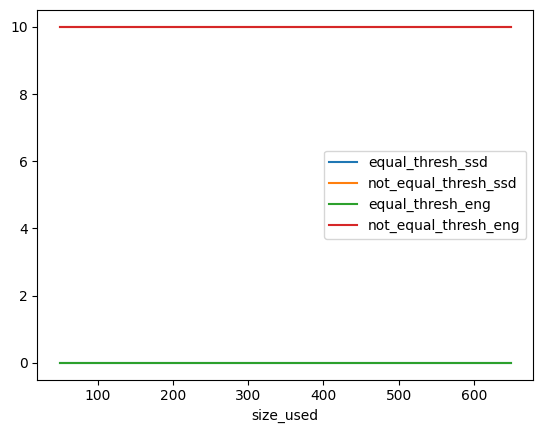

In [36]:
# group the data by the size_used field
grouped_data = size_fields_df.groupby('size_used')

# count the number of times seen_data_numeric equals mro_ssd and does not equal mro_ssd
equal_thresh_ssd = grouped_data['size_used'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].eq(grouped_data.get_group(x.name)['thresh_ssd'])).sum())
not_equal_thresh_ssd = grouped_data['size_used'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].ne(grouped_data.get_group(x.name)['thresh_ssd'])).sum())

# do the same for mro_eng
equal_thresh_eng = grouped_data['size_used'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].eq(grouped_data.get_group(x.name)['thresh_eng'])).sum())
not_equal_thresh_eng = grouped_data['size_used'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].ne(grouped_data.get_group(x.name)['thresh_eng'])).sum())

# create a new dataframe with the results
results_df = pd.DataFrame({'equal_thresh_ssd': equal_thresh_ssd,
                           'not_equal_thresh_ssd': not_equal_thresh_ssd,
                           'equal_thresh_eng': equal_thresh_eng,
                           'not_equal_thresh_eng': not_equal_thresh_eng})

results_df.plot()
plt.show()


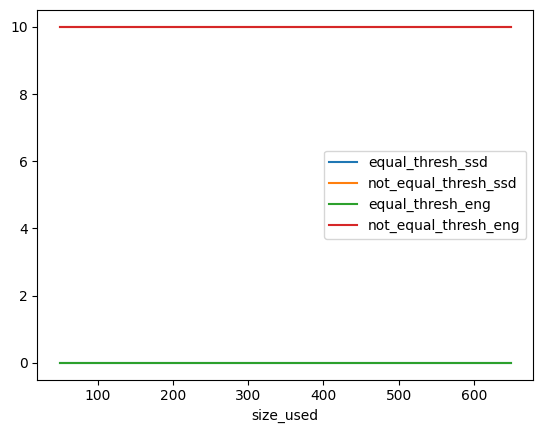

In [37]:
# group the data by the size_used field
grouped_data = size_fields_df.groupby('size_used')

# count the number of times seen_data_numeric equals mro_ssd and does not equal mro_ssd
equal_thresh_ssd = grouped_data['seen_data_numeric'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].eq(grouped_data.get_group(x.name)['thresh_ssd'])).sum())
not_equal_thresh_ssd = grouped_data['seen_data_numeric'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].ne(grouped_data.get_group(x.name)['thresh_ssd'])).sum())

# do the same for mro_eng
equal_thresh_eng = grouped_data['seen_data_numeric'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].eq(grouped_data.get_group(x.name)['thresh_eng'])).sum())
not_equal_thresh_eng = grouped_data['seen_data_numeric'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].ne(grouped_data.get_group(x.name)['thresh_eng'])).sum())

# create a new dataframe with the results
results_df = pd.DataFrame({'equal_thresh_ssd': equal_thresh_ssd,
                           'not_equal_thresh_ssd': not_equal_thresh_ssd,
                           'equal_thresh_eng': equal_thresh_eng,
                           'not_equal_thresh_eng': not_equal_thresh_eng})

results_df.plot()
plt.show()


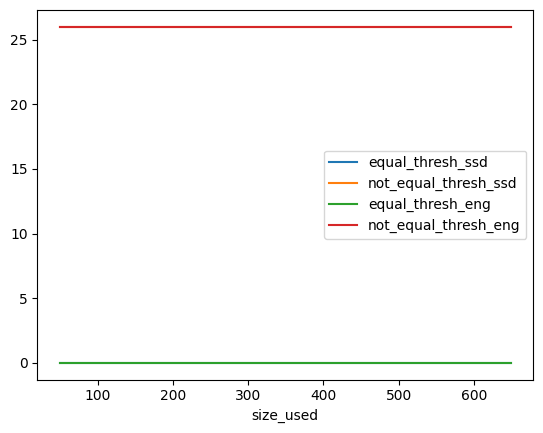

In [34]:
# group the data by the size_used field
grouped_data = size_fields_df.groupby('size_used')

# count the number of times seen_data_numeric equals mro_ssd and does not equal mro_ssd
equal_thresh_ssd = grouped_data['size_used'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].eq(grouped_data.get_group(x.name)['thresh_ssd'])).sum())
not_equal_thresh_ssd = grouped_data['size_used'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].ne(grouped_data.get_group(x.name)['thresh_ssd'])).sum())

# do the same for mro_eng
equal_thresh_eng = grouped_data['size_used'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].eq(grouped_data.get_group(x.name)['thresh_eng'])).sum())
not_equal_thresh_eng = grouped_data['size_used'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].ne(grouped_data.get_group(x.name)['thresh_eng'])).sum())

# create a new dataframe with the results
results_df = pd.DataFrame({'equal_thresh_ssd': equal_thresh_ssd,
                           'not_equal_thresh_ssd': not_equal_thresh_ssd,
                           'equal_thresh_eng': equal_thresh_eng,
                           'not_equal_thresh_eng': not_equal_thresh_eng})

results_df.plot()
plt.show()


size_used
50     0
51     0
52     0
53     0
54     0
      ..
645    0
646    0
647    0
648    0
649    0
Name: seen_data_numeric, Length: 600, dtype: int64


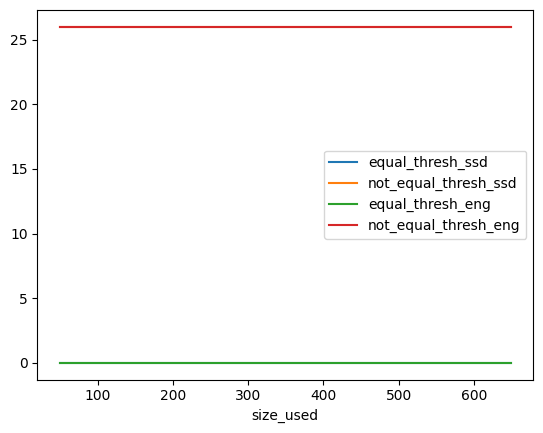

In [36]:
# group the data by the size_used field
grouped_data = size_fields_df.groupby('size_used')

# count the number of times seen_data_numeric equals mro_ssd and does not equal mro_ssd
equal_thresh_ssd = grouped_data['seen_data_numeric'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].eq(grouped_data.get_group(x.name)['thresh_ssd'])).sum())
print(equal_thresh_ssd)
not_equal_thresh_ssd = grouped_data['seen_data_numeric'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].ne(grouped_data.get_group(x.name)['thresh_ssd'])).sum())

# do the same for mro_eng
equal_thresh_eng = grouped_data['seen_data_numeric'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].eq(grouped_data.get_group(x.name)['thresh_eng'])).sum())
not_equal_thresh_eng = grouped_data['seen_data_numeric'].apply(lambda x: (grouped_data.get_group(x.name)['seen_data_numeric'].ne(grouped_data.get_group(x.name)['thresh_eng'])).sum())

# create a new dataframe with the results
results_df = pd.DataFrame({'equal_thresh_ssd': equal_thresh_ssd,
                           'not_equal_thresh_ssd': not_equal_thresh_ssd,
                           'equal_thresh_eng': equal_thresh_eng,
                           'not_equal_thresh_eng': not_equal_thresh_eng})

results_df.plot()
plt.show()
